In [1]:
# baseline model with dropout and data augmentation on the cifar10 dataset
import sys

import matplotlib
import matplotlib.pyplot as plt

from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout
from keras.layers import BatchNormalization

In [2]:
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY


In [3]:
# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

In [4]:
# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
	model.add(BatchNormalization())
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.2))
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.3))
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
	model.add(BatchNormalization())
	model.add(MaxPooling2D((2, 2)))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
	model.add(BatchNormalization())
	model.add(Dropout(0.5))
	model.add(Dense(10, activation='softmax'))
	opt = SGD(learning_rate=0.001, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model
	

In [5]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	plt.subplot(211)
	plt.title('Cross Entropy Loss')
	plt.plot(history.history['loss'], color='blue', label='train')
	plt.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	plt.subplot(212)
	plt.title('Classification Accuracy')
	plt.plot(history.history['accuracy'], color='blue', label='train')
	plt.plot(history.history['val_accuracy'], color='orange', label='test')
	# save plot to file
	filename = "temp"
	plt.savefig(filename + '_plot.png')
	# plt.close()

Epoch 1/10
1563/1563 - 23s - loss: 1.8795 - accuracy: 0.3530 - val_loss: 1.4431 - val_accuracy: 0.4802 - 23s/epoch - 15ms/step
Epoch 2/10
1563/1563 - 16s - loss: 1.4537 - accuracy: 0.4727 - val_loss: 1.3112 - val_accuracy: 0.5289 - 16s/epoch - 10ms/step
Epoch 3/10
1563/1563 - 15s - loss: 1.3079 - accuracy: 0.5286 - val_loss: 1.1882 - val_accuracy: 0.5613 - 15s/epoch - 10ms/step
Epoch 4/10
1563/1563 - 16s - loss: 1.1924 - accuracy: 0.5721 - val_loss: 1.0654 - val_accuracy: 0.6225 - 16s/epoch - 10ms/step
Epoch 5/10
1563/1563 - 15s - loss: 1.1104 - accuracy: 0.6052 - val_loss: 1.0537 - val_accuracy: 0.6158 - 15s/epoch - 10ms/step
Epoch 6/10
1563/1563 - 16s - loss: 1.0510 - accuracy: 0.6289 - val_loss: 1.0945 - val_accuracy: 0.6064 - 16s/epoch - 10ms/step
Epoch 7/10
1563/1563 - 18s - loss: 0.9949 - accuracy: 0.6473 - val_loss: 0.8876 - val_accuracy: 0.6828 - 18s/epoch - 12ms/step
Epoch 8/10
1563/1563 - 16s - loss: 0.9540 - accuracy: 0.6640 - val_loss: 0.8301 - val_accuracy: 0.7084 - 16s/ep

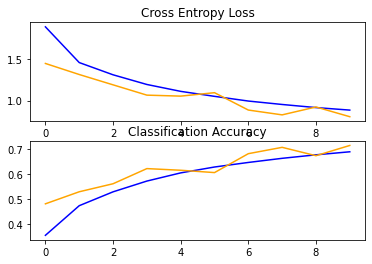

In [6]:
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# define model
	model = define_model()
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(trainX, trainY, batch_size=32)
	# fit model
	steps = int(trainX.shape[0] / 32)
	history = model.fit(trainX, trainY, validation_data=(testX, testY) , epochs=10, batch_size=32, verbose=2)
	# evaluate model
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)

	model.save('VGG16_model.h5')
	return history, model
 
# entry point, run the test harness
history, final_model = run_test_harness()

In [7]:
# Saving the model for Future Inferences

model_json = final_model.to_json()
with open("final_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
final_model.save_weights("final_model.h5")

In [14]:
# evaluate the deep model on the test dataset
from keras.datasets import cifar10
from keras.models import load_model
from tensorflow.keras.utils import to_categorical

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = cifar10.load_data()
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# run the test harness for evaluating a model
def run_test_harness():
	# load dataset
	trainX, trainY, testX, testY = load_dataset()
	# prepare pixel data
	trainX, testX = prep_pixels(trainX, testX)
	# load model
	model = load_model('VGG16_model.h5')
	# evaluate model on test dataset
	_, acc = model.evaluate(testX, testY, verbose=0)
	print('> %.3f' % (acc * 100.0))

# entry point, run the test harness
run_test_harness()

> 71.600


In [9]:
import cv2
import numpy as np

In [10]:
x = cv2.imread('images/airplane1.png', cv2.IMREAD_GRAYSCALE)
# print(x)
# x = np.invert(x)
res = cv2.resize(x, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
res = res.reshape(1,32,32,1)

In [29]:
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
# load model
(trainX, trainY), (testX, testY) = cifar10.load_data()

model = load_model('VGG16_model.h5')
# trainX, tmp = prep_pixels(res, res)
# trainX = np.array(trainX)
x = []
x.append(trainX[7])
x = np.array(x)
out = model.predict(x)
out = np.array(out)
response = class_names[np.argmax(out, axis=1)[0]]
print(response)

horse


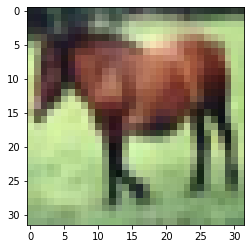

In [30]:
plt.imshow(trainX[7])